# Clasificación binaria de imágenes
## Oswaldo Alan Vergara Eslava
### Última modificación el 25 de abril del 2025
  En este programa se entrena a un modelo de aprendizaje profundo basado en ResNet50 para enseñar a la computadora a diferencir imágenes clasificadas en dos clases. Para este ejemplo, se utiliza un meme que estuvo circulando por internet donde pretendían confundir al aprendizaje de máquina con imágenes de chihuahuas y muffins donde las chispas de chocolate parecían ser los ojos y nariz de los perritos.
  Con una base de datos descargada de [KaggleHub](https://www.kaggle.com/datasets/samuelcortinhas/muffin-vs-chihuahua-image-classification) se pretende entrenar a la máquina para reconocer si una imagen es un chihuahua o un muffin, relacionado estréchamente a problemas de clasificación binaria de imágenes.

Se importan las librerías, comenzando con la importación de imágenes, el tratamiento de las mismas y la graficación del rendimiento del modelo entrenado.

In [3]:
#importación de datos
from tensorflow.keras.utils import image_dataset_from_directory

#tratamiento de imágenes
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics import confusion_matrix, classification_report

#gráficos
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Se importa la base de datos. La base descargada desde KaggleHub ya tiene separadas las clases y los datos de entrenamiento/validación.

In [4]:
#Reemplazar por la ruta original donde descargaste la carpeta principal "archive"
path="Documents/Ciencia de Datos/Image_treatment/archive"

#rutas a datos test y train respectivamente
path_test=path+"/test"
path_train=path+"/train"

Se importan y dividen los datos de entrenamiento y validación, y se les asigna un tamaño estándar de imágen.

In [5]:
train_img=image_dataset_from_directory(
    path_train,
    seed=42,
    image_size=(224, 224),
    batch_size=32
)

test_img=image_dataset_from_directory(
    path_test,
    seed=42,
    image_size=(224, 224),
    batch_size=32
)

#print(train_img.class_names)
#print(test_img.class_names)

Found 4733 files belonging to 2 classes.
Found 1184 files belonging to 2 classes.


Se realiza la optimización del **pipline** (secuencia de pasos), cargando individualmente cada conjunto de entrenamiento/validación.

In [6]:
#Optimiza el pipline
AUTOTUNE = tf.data.AUTOTUNE

#pipline
train_ds = (
    train_img        #Imágenes e entrenamiento
    .cache()         #Almacena datos en memoria para no recalcular
    .shuffle(1000)   #Mezcla el orden de las imágenes
    .map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE)        #Aplica la normalización de ResNet50
    .prefetch(AUTOTUNE)        #Prepara el siguiente batch mientras entrena
)

test_ds = (
    test_img
    .cache()
    .map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
)

**OPCIONAL:** Se realiza un aumento en los datos, realizando rotaciones, zoom y espejeos aleatorios a las imágenes de entrenamiento.

In [7]:
#Aumento de datos (opcional)
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),    #Voltea aleatoriamente imágenes en espejo (Horizontal 50% de probabilidad)
    layers.RandomRotation(0.1),         #Rota aleatoriamente hasta +- 0.1 rads
    layers.RandomZoom(0.1),             #Hace un zoom aleatorio de hasta 10%
])

Se constuye el modelo ResNet50, que es un modelo pre-entrenado al cual se le van a "congelar" los pesos que ya fueron pre entrenados para trabajar únicamente con la "cabecera" (base.trainable=False).

Se fijan los valores de entrada a imágenes de 224 pixeles de alto, 224 de ancho y 3 canales (RGB). A los valores de salida se les aplica el preprocesamiento, como la optimización del pipline o el aumento de datos.

Para mejorar el aprendizaje del modelo, se apagan el 20% de las neuronas aleatoriamente.

In [8]:
#Construcción del modelo con Functional API
inputs=tf.keras.Input(shape=(224, 224, 3))
x=data_augmentation(inputs)            #Aumento de datos
x=preprocess_input(x)                  #Preprocesamiento de ResNet50
base=ResNet50(include_top=False,       #Carga de ResNet50 sin la cabecera
                 weights="imagenet",
                 input_tensor=x,
                 pooling=None)
base.trainable=False                   #congela los pesos del backbone

x=base.output
x=layers.GlobalAveragePooling2D()(x)   #Pooling global
x=layers.Dropout(0.2)(x)               #Apaga aleatoriamente el 20% de las neuronas
outputs=layers.Dense(1, activation="sigmoid")(x)  #Capa final binaria

model = tf.keras.Model(inputs, outputs, name="resnet50")

Se compila el modelo utilizando el optimizador Adam con una razón de aprendizaje moderada y a *binary_crossentropy* como función de pérdida, siendo útil para clasificación binaria. El modelo utilizará la métrica de precisión (**accuracy**).

Se tienen 2,049 parámetros entrenables contra 23,587,712 debido a los pesos congelados en el backbone (*Ver la celda anterior*), asegurando que así sólo se entrenarán los datos nuevos, optimizando el tiempo de cómputo y la precisión de las predicciones.

In [9]:
#Compilación
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 224, 224, 3)  0          ['sequential[0][0]']             
 ingOpLambda)                                                                                     
                                                                                           

Se entrena al modelo en 20 épocas. Éste número se puede modificar.

In [10]:
#Entrenamiento
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=20,
    verbose=1
)

Epoch 1/20
148/148 [==============================] - 51s 245ms/step - loss: 0.3661 - accuracy: 0.8373 - val_loss: 0.1347 - val_accuracy: 0.9620
Epoch 2/20
148/148 [==============================] - 35s 234ms/step - loss: 0.1628 - accuracy: 0.9510 - val_loss: 0.0822 - val_accuracy: 0.9721
Epoch 3/20
148/148 [==============================] - 35s 236ms/step - loss: 0.1177 - accuracy: 0.9632 - val_loss: 0.0640 - val_accuracy: 0.9738
Epoch 4/20
148/148 [==============================] - 35s 233ms/step - loss: 0.0944 - accuracy: 0.9708 - val_loss: 0.0539 - val_accuracy: 0.9764
Epoch 5/20
148/148 [==============================] - 35s 234ms/step - loss: 0.0830 - accuracy: 0.9738 - val_loss: 0.0497 - val_accuracy: 0.9780
Epoch 6/20
148/148 [==============================] - 35s 237ms/step - loss: 0.0756 - accuracy: 0.9765 - val_loss: 0.0442 - val_accuracy: 0.9814
Epoch 7/20
148/148 [==============================] - 35s 234ms/step - loss: 0.0698 - accuracy: 0.9774 - val_loss: 0.0397 - val_ac

Se evalúa el modelo observando cómo se comportó su precisión y la función de perdida a lo largo del entrnamiento. EL modelo aprendió muy rápido, alcanzando una presición superior al 90% en las primeras tres épocas, y los datos de validación indican que no hubo overfitting durante el entrenamiento.

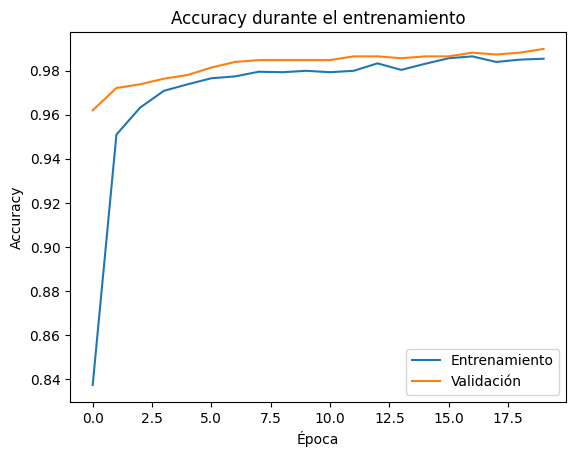

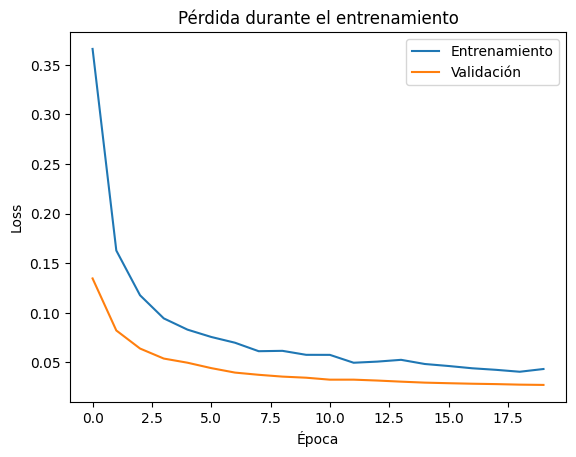

In [11]:
# Accuracy
plt.plot(history.history["accuracy"], label='Entrenamiento')
plt.plot(history.history["val_accuracy"], label='Validación')
plt.title("Accuracy durante el entrenamiento")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Pérdida
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.show()

Evaluando al modelo con los datos de testeo, se tuvo una pérdida del 2% con una precisión del 99%.

In [12]:
loss, acc = model.evaluate(test_ds, verbose=0)
print(f"Pérdida: {loss:.4f},  Precisión: {acc:.4f}")

Pérdida: 0.0273,  Precisión: 0.9899


Se muestran 5 ejemplos aleatorios de la muestra de imágenes de validación (testeo) con la predicción del modelo entrenado y lo que son realmente, para poder verificar visualmente lo que el modelo está prediciendo.

1/1 [==============================] - 0s 13ms/step


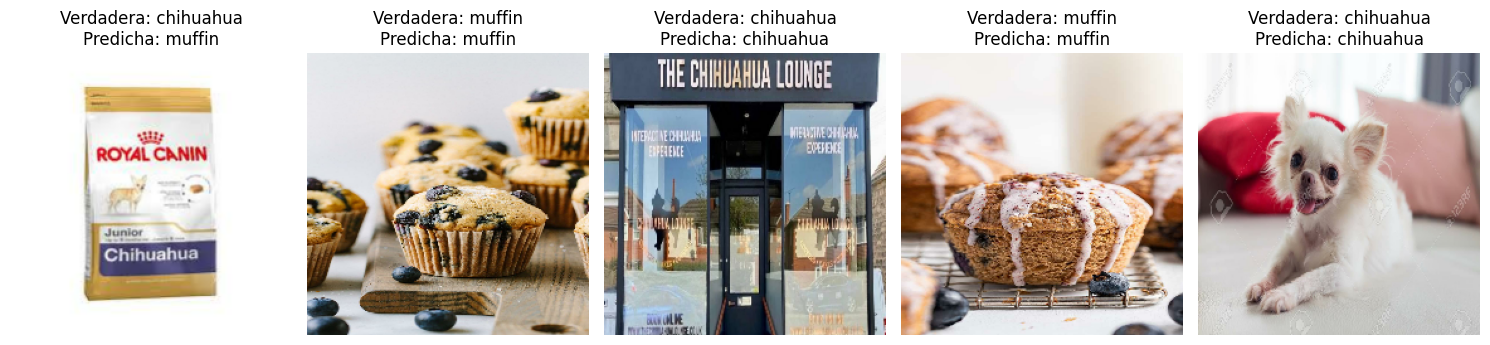

In [13]:
class_names=test_img.class_names
ds=test_img.unbatch().take(5)      #Muestra aleatoria de 5 imágenes

plt.figure(figsize=(15,5))

for i, (image, label) in enumerate(ds):
    logits=model.predict(tf.expand_dims(image, 0))
    pred_index=int(tf.squeeze(logits)>0.5)
    
    true_label=class_names[int(label)]          #etiquetas de valor predicho y el valor real
    pred_label=class_names[(pred_index)]
    
    ax=plt.subplot(1, 5, i+1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(f"Verdadera: {true_label}\nPredicha: {pred_label}")
    plt.axis("off")

plt.tight_layout()
plt.show()

Se muestra la matriz de confusión, lo que nos permite observar cuántas imágenes fueron clasificadas correctamente y cuántas no, incluso individualmente por cada clase (**Chihuahua**, **Muffin** para este caso).

1/1 [==============================] - 0s 32ms/step


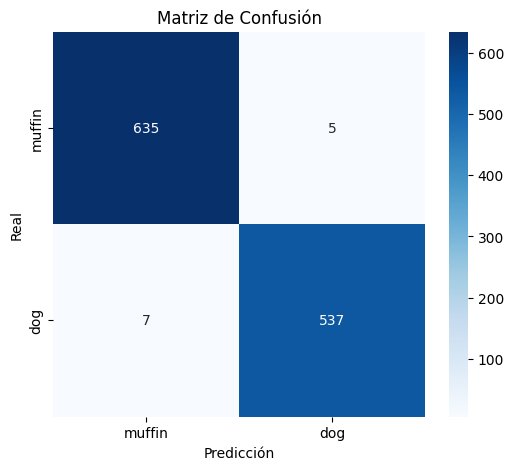

              precision    recall  f1-score   support

      muffin       0.99      0.99      0.99       640
         dog       0.99      0.99      0.99       544

    accuracy                           0.99      1184
   macro avg       0.99      0.99      0.99      1184
weighted avg       0.99      0.99      0.99      1184



In [14]:
y_true = []
y_pred = []
for images, labels in test_ds.unbatch().batch(32):
    probs = model.predict(images)
    preds = (probs > 0.5).astype(int).flatten()
    y_pred.extend(preds)
    y_true.extend(labels.numpy().flatten())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=['muffin','dog'],
            yticklabels=['muffin','dog'],
            cmap='Blues')
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

print(classification_report(y_true, y_pred, target_names=['muffin','dog']))